# Homework 4: Applied Machine Learning

In [1]:
import pandas as pd                                     
import numpy as np                                              
import matplotlib.pyplot as plt 
import scipy.stats.mstats as ssm
import sklearn
from sklearn import preprocessing
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import random

%matplotlib inline

/Users/dmartr/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First we import the data frame and we take a look at it: 

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.set_index(data.columns[0], inplace = True)
data.head()

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,,,,
lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [3]:
#data.set_index(data.columns[0], inplace = True)
data.dtypes

player            object
club              object
leagueCountry     object
birthday          object
height           float64
weight           float64
position          object
games              int64
victories          int64
ties               int64
defeats            int64
goals              int64
yellowCards        int64
yellowReds         int64
redCards           int64
photoID           object
rater1           float64
rater2           float64
refNum             int64
refCountry         int64
Alpha_3           object
meanIAT          float64
nIAT             float64
seIAT            float64
meanExp          float64
nExp             float64
seExp            float64
dtype: object

As we can observe the data column type is not consistent. We need to convert all the data to float, otherwise we might have some trouble processing the random forest classifier.

In [4]:
def convertColumns(dataframe):
    for c in dataframe.columns:
        if not (dataframe[c].dtype in ['int64', 'float64']):
            dataframe[c] = dataframe[c].astype('category').cat.codes
convertColumns(data)
data.dtypes

player             int16
club                int8
leagueCountry       int8
birthday           int16
height           float64
weight           float64
position            int8
games              int64
victories          int64
ties               int64
defeats            int64
goals              int64
yellowCards        int64
yellowReds         int64
redCards           int64
photoID            int16
rater1           float64
rater2           float64
refNum             int64
refCountry         int64
Alpha_3            int16
meanIAT          float64
nIAT             float64
seIAT            float64
meanExp          float64
nExp             float64
seExp            float64
dtype: object

We will need a function to sample the rater values as this will help to classify the data: 

In [5]:
def skinLabels(rater):
    if  rater <= 0.5:
        rater = 0
    else:
        rater = 1
    return rater

Every string is encoded as integer by mapping each possible value to a number. We also merged the two rater values computing as the mean and stored it in `skincolor`. The `skincolor` must be sampled to 0 or 1 using the previous function:

In [6]:
players = data.copy()

label_encoder = preprocessing.LabelEncoder()
players['club'] = label_encoder.fit_transform(data['club'])
players['leagueCountry'] = label_encoder.fit_transform(data['leagueCountry'])
players['position'] = label_encoder.fit_transform(data['position'])
players['skincolor'] = [skinLabels(x) for x in ((data['rater1']+data['rater2'])/2).values]
players = players.dropna(axis = 0, subset=['skincolor'])
players.drop(['rater1', 'rater2'], inplace=True, axis=1)
players.head()

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skincolor
playerShort,,,,,,,,,,,,,,,,,,,,,
lucas-wilchez,1341,82,3,1714,177.0,72.0,1,1,0,0,...,1,1,60,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0
john-utaka,1158,62,1,396,179.0,82.0,12,1,0,0,...,2,2,158,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,1
abdon-prats,0,73,3,966,181.0,79.0,0,1,0,1,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,1
pablo-mari,296,73,3,1716,191.0,87.0,2,1,1,0,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,1
ruben-pena,355,81,3,1015,172.0,70.0,11,1,1,0,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,1


## Task 1: Random Forest Classifier

In this task we will use the data of the players without the referees influence. We will create a new dataframe with the columns `player`, `height`, `weight`, `club` and `position` representing the features matrix X in our Supervised ML model and the column `skincolor` representing the Y.

We also need to prepare our features. 

In [7]:
players_wr = players[['player', 'height', 'weight', 'club', 'leagueCountry', 'position', 'skincolor']].copy()
print(players_wr.size)
players_wr.head()

1022196


,player,height,weight,club,leagueCountry,position,skincolor
playerShort,,,,,,,
lucas-wilchez,1341,177.0,72.0,82,3,1,0
john-utaka,1158,179.0,82.0,62,1,12,1
abdon-prats,0,181.0,79.0,73,3,0,1
pablo-mari,296,191.0,87.0,73,3,2,1
ruben-pena,355,172.0,70.0,81,3,11,1


We drop the duplicates. Also, the NA values must be procesed, we computed the missing values as the mean of the non-missing values. We also standarized the `height` and `weight` values.  

In [8]:
new_players_wr = players_wr.drop_duplicates(['player'], keep='first')

new_players_wr.loc[:, 'height'] = new_players_wr.loc[:, 'height'].fillna(np.mean(new_players_wr.loc[:, 'height'].dropna()))
new_players_wr.loc[:, 'weight'] = new_players_wr.loc[:, 'weight'].fillna(np.mean(new_players_wr.loc[:, 'weight'].dropna()))
new_players_wr.loc[:, 'club'] = new_players_wr.loc[:, 'club'].fillna(np.mean(new_players_wr.loc[:, 'club'].dropna()))
new_players_wr.loc[:, 'leagueCountry'] = new_players_wr.loc[:, 'leagueCountry'].fillna(np.mean(new_players_wr.loc[:, 'leagueCountry'].dropna()))
new_players_wr.loc[:, 'position'] = new_players_wr.loc[:, 'position'].fillna(np.mean(new_players_wr.loc[:, 'position'].dropna()))

/Users/dmartr/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The height and weight values needs to be standarized.

In [9]:
new_players_wr['height'] = (new_players_wr['height']-new_players_wr['height'].mean())/new_players_wr['height'].std()
new_players_wr['weight'] = (new_players_wr['weight']-new_players_wr['weight'].mean())/new_players_wr['weight'].std()

/Users/dmartr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/dmartr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
new_players_wr.head()

,player,height,weight,club,leagueCountry,position,skincolor
playerShort,,,,,,,
lucas-wilchez,1341,-0.713788,-0.525389,82,3,1,0
john-utaka,1158,-0.414138,0.907424,62,1,12,1
abdon-prats,0,-0.114489,0.477580,73,3,0,1
pablo-mari,296,1.383759,1.623830,73,3,2,1
ruben-pena,355,-1.462912,-0.811952,81,3,11,1


We create the Random Forest using different combinations of parameters and perform a cross validations to compare them: 

In [11]:
X = new_players_wr.drop(['skincolor'], axis=1)
Y = new_players_wr['skincolor']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=666)
k_fold = KFold(x_train.shape[0], n_folds = 20, shuffle=True)
scores = []
importances = np.zeros(5)
for train_indices, test_indices in k_fold:
    rf = RandomForestClassifier(n_estimators=20)
    rf.fit(x_train.iloc[train_indices][['height','weight','club', 'leagueCountry','position']], y_train[train_indices])
    score = rf.score(x_train.iloc[test_indices][['height','weight','club', 'leagueCountry','position']], y_train[test_indices])
    importance = np.asarray(rf.feature_importances_)
    scores.append(score)
    importances = np.add(importances,importance)

print(np.array(scores).mean(), np.array(scores).std())

0.744814220797 0.0413940826165


In [13]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(x_train[['height','weight','club', 'leagueCountry','position']], y_train)
print(rf.score(x_test[['height','weight','club', 'leagueCountry','position']], y_test))

0.751633986928


Feature ranking (1. most important):
1. Feature name: 'weight'. Feature index: 2. Importance score: 0.239036
2. Feature name: 'height'. Feature index: 1. Importance score: 0.202658
3. Feature name: 'leagueCountry'. Feature index: 4. Importance score: 0.192630
4. Feature name: 'player'. Feature index: 0. Importance score: 0.189268
5. Feature name: 'club'. Feature index: 3. Importance score: 0.176408


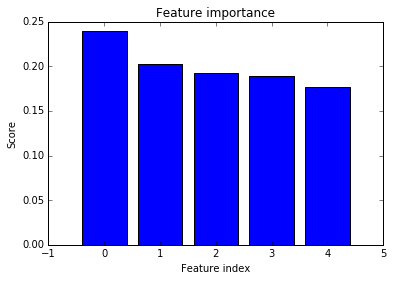

In [14]:
def plot_importance(forest, features_list):
    features = x_train[features_list].columns
    importances = forest.feature_importances_
    order = np.argsort(importances)[::-1]
    print("Feature ranking (1. most important):")
    for i in range(X.shape[1]-1):
        print("%d. Feature name: '%s'. Feature index: %d. Importance score: %f" % (i + 1, features[order[i]], order[i], importances[order[i]]))
    plt.figure()
    plt.title("Feature importance")
    plt.xlabel("Feature index")
    plt.ylabel("Score")
    plt.bar(range(X.shape[1]-1), importances[order], color="b", align="center")
    plt.show()

plot_importance(rf, x_train.columns.tolist())

As a conclusion, we show the results for the Random Forest Classifier with two diferents feature sets (with the referee information and without it) in a 20-Fold cross-validation (this results are obtained by using the X showed before or the X obtained in the next task):

In [24]:
new_players_wr = players.copy()
new_players_wr.reset_index(inplace=True, drop=False)
new_players_wr.drop(['player', 'photoID', 'birthday', "refNum", "refCountry"], inplace=True, axis=1)
new_players_wr.columns
new_players_wr = new_players_wr.groupby(["playerShort","club","leagueCountry", "position"])
groups = {'height' : np.mean, 'weight' : np.mean, 'games' : np.sum, 'victories' : np.sum, 
                 'ties' : np.sum, 'defeats' : np.sum, 'goals' : np.sum, 'yellowCards' : np.sum, 
                 'redCards' : np.sum, 'skincolor' : np.mean, 'meanIAT': np.mean, 'meanExp': np.mean, 'seIAT': np.mean, 
                 'seExp': np.mean}
new_players_wr = new_players_wr.agg(groups)
new_players_wr.dropna(inplace=True)

X = new_players_wr.drop(['skincolor'], axis=1)
Y = new_players_wr['skincolor']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=666)
k_fold = KFold(x_train.shape[0], n_folds = 20, shuffle=True)
scores = []
for train_indices, test_indices in k_fold:
    rf = RandomForestClassifier(n_estimators=20)
    rf.fit(x_train.iloc[train_indices][X.columns.tolist()], y_train[train_indices])
    score = rf.score(x_train.iloc[test_indices][X.columns.tolist()], y_train[test_indices])
    importance = np.asarray(rf.feature_importances_)
    scores.append(score)

print(np.array(scores).mean(), np.array(scores).std())

0.797238955823 0.0344436100537


To sum it up the results were: 

1. First RF (without referee info agg): Accuracies mean = 0.728080727078  Standard deviation = 0.046612632558
2. Second RF (with referee info agg): Accuracies mean = 0.797238955823   Standard deviation  = 0.0344436100537

We can appreciate that the Second Classifier is better than the second. To know if the RF Classifier is strong we can take a look at the STD of the scores in each tr. It actually obtains less STD than the accurary in each fold. Then, we can say that Classifier is strong because it makes the same performance in each folder. The second Classifier obtained increases 0,072 the accuracy and wins 0,01 in strength compared to the first classifier.

## Task 1 bonus: Plot the learning curves

Looking the scikit-learn learning curves documentation: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [18]:
from sklearn.learning_curve import learning_curve 
def plotLearningCurves (estimator, x, y):
    plt.figure()
    plt.title('Learning curves')
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, cv=20, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    return plt

<module 'matplotlib.pyplot' from '/Users/dmartr/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

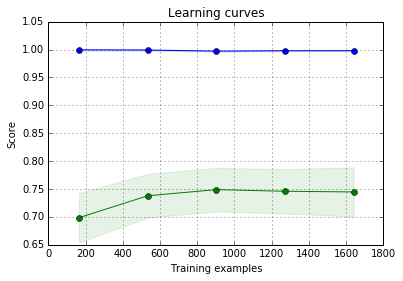

In [19]:
plotLearningCurves(rf, x_train[['height','weight','club', 'leagueCountry','position']], y_train)

<module 'matplotlib.pyplot' from '/Users/dmartr/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

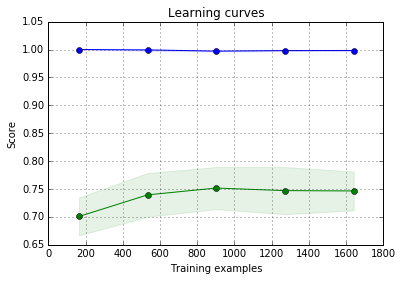

In [20]:
rf2 = rf = RandomForestClassifier(n_estimators=50, max_depth=30)
plotLearningCurves(rf2, x_train[['height','weight','club', 'leagueCountry','position']], y_train)

## Task 2: Unsupervised learning

In this task we want to cluster all the players with the referee data aggregated. To that we will work with most of the features. We drop the ones that gives us no information. The `player` column is dropped because we will use `playershort` instead for identify players. `photoID` and `bithday` are dropped because they give no releant information. `refNum` and `refCountry` are dropped because we are aggregating all the referee data for every player.  

In [25]:
def clean_data(players_grp):
    players_grp.reset_index(inplace=True, drop=False)
    players_grp.drop(['player', 'photoID', 'birthday', "refNum", "refCountry"], inplace=True, axis=1)
    print(players_grp.columns)
    players_grp = players_grp.groupby(["playerShort","club","leagueCountry", "position"])
    groups = {'height' : np.mean, 'weight' : np.mean, 'games' : np.sum, 'victories' : np.sum, 
                     'ties' : np.sum, 'defeats' : np.sum, 'goals' : np.sum, 'yellowCards' : np.sum, 
                     'redCards' : np.sum, 'skincolor' : np.mean, 'meanIAT': np.mean, 'meanExp': np.mean, 'seIAT': np.mean, 
                     'seExp': np.mean}
    players_grp = players_grp.agg(groups)
    return players_grp

In our model the X is the all the features:

In [26]:
X = clean_data(players.copy())._get_numeric_data()

Index(['playerShort', 'club', 'leagueCountry', 'height', 'weight', 'position',
       'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards',
       'yellowReds', 'redCards', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'skincolor'],
      dtype='object')


To perform the learning task, we decided to use a kmeans classifier with k=2 because we have unlabeled data (we want to cluster the data en 2 clusters). To study the importance of every feature we clustered the data multiple times, each time dropping a feature (different from skincolor, as this is our most important feature) and calculated the silhoutte score.

In [27]:
kmean = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=500, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
pca = PCA(2)
silhouette_scores = []
avg_skintones = []
for i in range (X.shape[1]-1, 1, -1):
    if(X.columns[i] != 'skincolor'):
        X = X.drop(X.columns[i], axis=1)
        kmean.fit(X)
        labels = kmean.labels_
        print("Features:", X.columns.tolist())
        print("Silhoutte score:", sklearn.metrics.silhouette_score(X, labels, metric='euclidean'))
        print("Skincolor average:",X.groupby(labels).mean()['skincolor'].values)
        #plotting of the clusters
        plot_columns = pca.fit_transform(X)
        plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
        plt.show()


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

It seems that the combinations of the features `seIAT`, `meanExp`, `games` and `skincolor` returns a classifier with a good silhoutte score and the two clusters are perfectly differentiated. 